This is the notebook for the signal processing of a magnet signal in the lecture Sensors and Signal Processing.

In [86]:
#!pip install plotly

In [87]:
import numpy as np
import pandas as pd
import os
import seaborn
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.linear_model import LinearRegression

In [88]:
# Read in file paths

file_paths = [f"./data_raw/Raw Data-{i}.csv" for i in range(1, 5)]
dfs = []

# Iterate over each file, read it into a dataframe, and add a column for experiment index
for idx, file_path in enumerate(file_paths, start=1):
    df = pd.read_csv(file_path)
    df['Experiment_Index'] = idx
    dfs.append(df)

# Put the dataframes together
combined_df = pd.concat(dfs, ignore_index=True)
threshold_value = 100

# Lists for indices where it rises and falls back down to normal values (no external magnetic field)
sharp_rise_indices = []
descent_indices = []
for experiment_idx, group_df in combined_df.groupby('Experiment_Index'):
    # Find sharp rise index
    sharp_rise_index = group_df['Absolute field (µT)'].diff().gt(threshold_value).idxmax()
    sharp_rise_indices.append(sharp_rise_index)

    # Find descent index
    start_index = group_df.index.get_loc(sharp_rise_index)  # Start searching from sharp rise index
    sharp_rise_value = group_df.loc[sharp_rise_index, 'Absolute field (µT)']
    threshold_descent = sharp_rise_value - threshold_value # Make sure the value is really significantly smaller
    descent_index = group_df.iloc[start_index:]['Absolute field (µT)'].lt(threshold_descent).idxmax()
    descent_indices.append(descent_index)

selected_rows = []
for sharp_rise_index, descent_index in zip(sharp_rise_indices, descent_indices):
    selected_rows.append(combined_df.loc[sharp_rise_index:descent_index])

selected_df = pd.concat(selected_rows)

print("Indices where a sharp rise occurs: ", sharp_rise_indices)
print("Indices where it descends again", descent_indices)

Indices where a sharp rise occurs:  [219, 1938, 3778, 5958]
Indices where it descends again [1147, 3071, 5081, 7118]


[0.0012936267516241119, 0.0006477436263677691, -0.0006606787834920368, -0.0013099933991832903]
[0.001291145211980288, 0.0006496608608352168, -0.0006496608608352168, -0.001291145211980288]


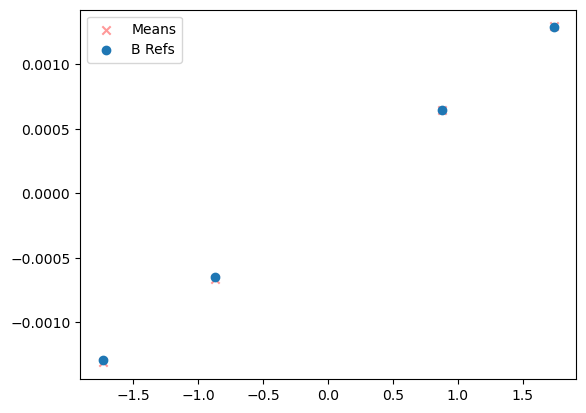

In [89]:
# Get the mean of measurements for each experiment and add it to a list
measured_means = []
for i in range(1,5):
    measured_mean = selected_df[selected_df['Experiment_Index'] == i]['Magnetic Field y (µT)'].mean()
    # measured_mean /= 10^6
    measured_means.append(measured_mean)
measured_means_in_T= [value / 1000000 for value in measured_means]
print(measured_means_in_T)

x = [1,2,3,4]
currents = [1.737, 0.874, -0.874, -1.737]

def B_ref(current):
    mu = 4 * np.pi * 10**(-7)
    N = 124
    R = 0.15
    return mu * (8*current*N) / (np.sqrt(125)*R)

brefs = []
for i in range(0,4):
    brefs.append(B_ref(currents[i]))
print(brefs)

plt.scatter(x=currents, y=measured_means_in_T, label='Means', marker='x', alpha=.4, color='red')
plt.scatter(x=currents, y=brefs, label='B Refs')
plt.legend()
plt.show()

In [90]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=currents, y=measured_means_in_T, mode='markers', marker=dict(size=12, opacity=0.5), name='Measured Means'))
fig.add_trace(go.Scatter(x=currents, y=brefs, mode='markers', marker=dict(size=6, opacity=0.8), name='Calculated B_refs'))

# Add title and axis labels
fig.update_layout(
    title="Scatter Plot of Currents vs Measured B_y and B_ref",
    xaxis_title="Currents [A]",
    yaxis_title="Magnetic Field [T]"
)

# Show the plot
fig.show()

In [91]:
slope, intercept, r_value, _, _ = scipy.stats.linregress(x=currents, y=measured_means_in_T)
print("The Pearson R coefficient for the measured means is: ", r_value)

The Pearson R coefficient for the measured means is:  0.999999528186711


### Tracking Data Extraction

In [122]:
path_to_tracking = "./data_raw/Raw Data-tracking.csv"
df_tracking = pd.read_csv(path_to_tracking)
df_tracking.head()

# Line plot of absolute field vs time
fig = px.line(df_tracking[:375], x='Time (s)', y='Magnetic Field z (µT)', title="Absolute Field vs. Time",
              line_shape='linear', render_mode='svg')
fig.show()

threshold_value = 50

# Calculate the differences between consecutive values and store them in a new column
df_tracking['diff'] = df_tracking['Absolute field (µT)'].diff()
pd.set_option('display.max_rows', 5)
display(df_tracking)

# Find indices of sharp rises and descents
rise_indices_tracking = df_tracking[df_tracking['diff'] > threshold_value].index.tolist()
descent_indices_tracking = df_tracking[(df_tracking['diff'].shift(-1) < -threshold_value)].index.tolist()
print(rise_indices_tracking)
print(descent_indices_tracking)


,Time (s),Magnetic Field x (µT),Magnetic Field y (µT),Magnetic Field z (µT),Absolute field (µT),diff
0,0.010507,37.711456,-53.869354,-63.459534,91.384756,NaN
1,0.020470,37.735016,-53.843094,-63.455551,91.376240,-0.008517
...,...,...,...,...,...,...
2220,22.128152,-250.930939,-687.661743,-35.059250,732.853437,-0.398357
2221,22.138114,-250.996170,-687.451965,-34.905167,732.671586,-0.181851


[53, 105, 106, 207, 208, 386, 436, 437, 540, 541, 719, 771, 772, 872, 873, 1052, 1101, 1102, 1204, 1205, 1384, 1435, 1436, 1538, 1539, 1716, 1767, 1768, 1869, 1870, 2050, 2100, 2101, 2201, 2202]
[156, 283, 284, 487, 614, 615, 820, 948, 949, 1152, 1280, 1281, 1486, 1612, 1613, 1816, 1946, 1947, 2150]


In [118]:
# Identify plateaus using rolling windows
def find_plateau_regions(df, threshold):
    """
    Find plateau regions in the signal data.

    Args:
    df (pd.DataFrame): DataFrame containing signal data.
    threshold (float): Threshold for detecting plateaus.

    Returns:
    dict: Dictionary containing plateau regions for each column.
    """
    plateau_regions_dict = {}

    for col in df.columns:
        # Smooth the signal data using rolling window averaging
        window_size = 2
        smoothed_signal = df[col].rolling(window=window_size, min_periods=1).mean()

        # Calculate the difference between consecutive smoothed values
        diff_smoothed_signal = smoothed_signal.diff()

        # Find indices where the difference is below the threshold
        plateau_indices = diff_smoothed_signal.abs() < threshold

        plateau_regions = []
        start_index = None
        for index, value in plateau_indices.items():
            if value:  # If the difference is below the threshold
                if start_index is None:
                    start_index = index  # Start of plateau region
            elif start_index is not None:
                end_index = index - 1  # End of plateau region
                plateau_regions.append((start_index, end_index))
                start_index = None

        plateau_regions_dict[col] = plateau_regions

    return plateau_regions_dict

threshold_value = .5
df_trunc = df_tracking[:400]
plateau_regions = find_plateau_regions(df_tracking[:400], threshold_value)
plateau_regions = dict(list(plateau_regions.items())[1:-1])
print(plateau_regions)

{'Magnetic Field x (µT)': [(1, 52), (58, 104), (111, 156), (163, 206), (213, 283), (290, 385)], 'Magnetic Field y (µT)': [(1, 52), (57, 104), (111, 156), (164, 206), (213, 283), (291, 385)], 'Magnetic Field z (µT)': [(1, 52), (58, 156), (159, 206), (212, 283), (288, 385)], 'Absolute field (µT)': [(1, 52), (58, 104), (111, 156), (163, 206), (213, 262), (264, 268), (270, 282), (290, 385)]}


In [121]:
# analyze plateaus and indices for all axes
# Print the values of the second key in plateau_regions_dict
second_key_x = list(plateau_regions.keys())[1]  # 0 = x, 1 = y, 2 = z
plateau_regions_values = plateau_regions[second_key_x]

print(f"Plateau regions for {second_key_x}:")
start_list = []
end_list = []
for start_index, end_index in plateau_regions_values:
    start_list.append(start_index)
    end_list.append(end_index)
    print(f"Start index: {start_index}, End index: {end_index}")

# Create a line plot of Magnetic Field x vs. Time
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_trunc['Time (s)'], y=df_trunc['Magnetic Field z (µT)'],
                         mode='lines', name='Magnetic Field z', line=dict(color='black')))

# Iterate through each pair of start and end indices
for i, (start_index, end_index) in enumerate(zip(start_list, end_list)):
    # Extract x and y values for the pair
    x_values = [df_trunc.loc[start_index, 'Time (s)'], df_trunc.loc[end_index, 'Time (s)']]
    y_values = [df_trunc.loc[start_index, 'Magnetic Field z (µT)'], df_trunc.loc[end_index, 'Magnetic Field z (µT)']]

    # Assign a different color to each pair
    color = f"hsl({i * 360 / len(start_list)}, 50%, 50%)"  # Adjust saturation and lightness as needed

    # Add a scatter trace for the pair with the assigned color
    fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='markers', marker=dict(color=color, size=9),
                             name=f'Plateau {i+1}'))

# Update layout
fig.update_layout(title='Magnetic Field z vs. Time with Plateau Regions',
                  xaxis_title='Time (s)',
                  yaxis_title='Magnetic Field z (µT)')

# Show the plot
fig.show()


Plateau regions for Magnetic Field y (µT):
Start index: 1, End index: 52
Start index: 57, End index: 104
Start index: 111, End index: 156
Start index: 164, End index: 206
Start index: 213, End index: 283
Start index: 291, End index: 385


In [117]:
def extract_mean(start_list, end_list, ax):
     """Extracts mean for each plateau

     Args:
         start_list (list): _description_
         end_list (list): _description_
         ax (str): x, y, z or nc - defines the axis that the median will find

     Returns:
         _type_: list of medians, index corresponds to A, B, C, D peaks.
     """
     medians = []
     col = ''
     if ax == 'x':
          col = 'Magnetic Field x (µT)'
     elif ax == 'y':
          col = 'Magnetic Field y (µT)'
     elif ax == 'z':
          col = 'Magnetic Field z (µT)'
     else:
          col = 'Absolute field (µT)'
     for i, (start_index, end_index) in enumerate(zip(start_list, end_list)):
          medians.append(np.median(df_trunc.loc[start_index:end_index, col]))
     return medians

meds_x = extract_mean(start_list=start_list, end_list=end_list, ax='x')
print('                (A:1,            B:2,           C:3,           NC:4 )')
print('Means for x - ', meds_x[1:])
meds_y = extract_mean(start_list=start_list, end_list=end_list, ax='y')
print('Means for y - ', meds_y[1:])
meds_z = extract_mean(start_list=start_list, end_list=end_list, ax='z')
print('Means for z - ', meds_z[1:])
meds_nc = extract_mean(start_list=start_list, end_list=end_list, ax='nc')
print('Means for abs - ', meds_nc[1:])


                (A:1,            B:2,           C:3,           NC:4 )
Means for x -  [101.8955078, -172.24816895, 109.0045471, -251.0875854, 37.92379761]
Means for y -  [-17.80672455, 495.97750855, -99.0912323, -688.1864014, -54.1237793]
Means for z -  [-137.67913055, -137.5864487, -139.2164764, -34.91616821, -63.51620483]
Means for abs -  [172.1978114, 542.75829545, 202.6850742, 733.3841159, 91.65405345]


In [95]:
# TODO: make a method to get the index for 3 axes.
def extract_index(df, col_str, threshold):
    """Extracts the indices where there is sharp rise and sharp descent to get the peaks of the signal.
        This method is specific to a dataframe from Phyphox.
    Args:
        df (pd.Dataframe): Dataframe to extract the indices from
        col_str (str): Column name as String
        threshold (int): Threshold for the difference
    """
    df_new = df.copy()
    df_new['diff'] = df_new[col_str].diff()

    # Find indices of sharp rises and descents
    rise_idx = df_new[df_new['diff'] > threshold].index.tolist()
    descent_idx = df_new[(df_new['diff'].shift(-1) < -threshold)].index.tolist()

    return rise_idx, descent_idx

In [96]:
# Analyze x and extract indices and subsequently the value to give it to Matlab
t = 40
df_trunc = df_tracking[:400]
rxidx, dxidx = extract_index(df_trunc, 'Magnetic Field x (µT)', t)
rxidx = [index + 1 for index in rxidx]

fig = px.line(df_trunc, x='Time (s)', y='Magnetic Field x (µT)', title="Magnetic Field x vs. Time",
              line_shape='linear', render_mode='svg')

fig.add_scatter(x=df_trunc.loc[rxidx, 'Time (s)'],
                y=df_trunc.loc[rxidx, 'Magnetic Field x (µT)'],
                mode='markers', marker=dict(color='red', size=8), name='Sharp Rise')
fig.add_scatter(x=df_trunc.loc[dxidx, 'Time (s)'],
                y=df_trunc.loc[dxidx, 'Magnetic Field x (µT)'],
                mode='markers', marker=dict(color='red', size=8), name='Descent')


In [97]:
# Line plot of absolute field vs time
fig = px.line(df_tracking, x='Time (s)', y='Absolute field (µT)', title="Absolute Field vs. Time",
              line_shape='linear', render_mode='svg')

fig.add_scatter(x=df_tracking.loc[rise_indices_tracking, 'Time (s)'],
                y=df_tracking.loc[rise_indices_tracking, 'Absolute field (µT)'],
                mode='markers', marker=dict(color='red', size=8), name='Sharp Rise')
fig.add_scatter(x=df_tracking.loc[descent_indices_tracking, 'Time (s)'],
                y=df_tracking.loc[descent_indices_tracking, 'Absolute field (µT)'],
                mode='markers', marker=dict(color='blue', size=8), name='Descent')

fig.show()